In [1]:
!nvidia-smi

Fri Sep 29 17:55:45 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.42                 Driver Version: 537.42       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2070 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8               7W /  30W |    286MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import pydot
from tensorflow.keras.preprocessing import image
import pydotplus
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, PReLU, Add, Multiply, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.layers import LSTM, Conv1D
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model


In [3]:
#Model


class_num = 2

# Define a custom attention block as a Keras Layer
class AttentionBlock(Layer):
    def __init__(self, filters, **kwargs):
        super(AttentionBlock, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        super(AttentionBlock, self).build(input_shape)
        self.F_g = Conv2D(self.filters, (1, 1), strides=(1, 1), padding='valid')
        self.F_x = Conv2D(self.filters, (1, 1), strides=(1, 1), padding='valid')

    def call(self, x):
        F_g = self.F_g(x)
        F_x = self.F_x(x)
        attn = Multiply()([F_g, F_x])
        return attn

# Define a residual block as a Keras Layer
class ResidualBlock(Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        super(ResidualBlock, self).build(input_shape)
        self.shortcut = Conv2D(self.filters, (1, 1), strides=(1, 1), padding='same')
        self.conv1 = Conv2D(self.filters, (3, 3), strides=(1, 1), padding='same', activation='PReLU')
        self.conv2 = Conv2D(self.filters, (3, 3), strides=(1, 1), padding='same', activation='PReLU')

    def call(self, x):
        shortcut = self.shortcut(x)  # Match the number of filters
        x = self.conv1(x)
        x = self.conv2(x)
        x = Add()([shortcut, x])
        return x

# Create the model
model = Sequential()

# Initial convolution layer with dilation
model.add(Conv2D(16, (3, 3), activation='PReLU', dilation_rate=(2, 2), input_shape=(224, 224, 3)))

# Max pooling layer
model.add(MaxPool2D(2, 2))

# Add residual blocks with dilation and attention
model.add(AttentionBlock(16))
model.add(ResidualBlock(32))
model.add(ResidualBlock(32))

model.add(AttentionBlock(32))
model.add(ResidualBlock(64))
model.add(ResidualBlock(64))

model.add(AttentionBlock(64))

# Max pooling layer
model.add(MaxPool2D(2, 2))

# Flatten the output
model.add(Flatten())

# Fully connected layers
model.add(Dense(1024, activation='PReLU'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(class_num, activation='softmax'))

model.summary()


# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 16)      774848    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 attention_block (AttentionB  (None, 110, 110, 16)     544       
 lock)                                                           
                                                                 
 residual_block (ResidualBlo  (None, 110, 110, 32)     788832    
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 110, 110, 32)     793952    
 lock)                                                  

In [4]:
op = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
  loss='categorical_crossentropy',
  optimizer=op,
  metrics=['accuracy']
)

model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  brightness_range=(0.4, 0.7),
                                  vertical_flip= True,
                                  horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(r'D:\Research\thesis\augmented\train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

val_set = val_datagen.flow_from_directory(r'D:\Research\thesis\augmented\val',
                                          target_size = (224,224),
                                          batch_size = 32,
                                          class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory(r'D:\Research\thesis\augmented\test',
                                           target_size = (224,224),
                                           batch_size = 1,
                                           class_mode = 'categorical')

Found 4200 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


In [6]:
filepath = r"D:\Research\thesis\augmented\weight\MainModel12.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=True,
                              save_best_only=True, mode='max')

log_csv = CSVLogger(r'D:\Research\thesis\augmented\weight\MainModel12.csv', separator=',', append=False)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max', restore_best_weights=True)

callbacks_list = [checkpoint1, log_csv, early_stopping]

train_steps_per_epoch = len(training_set)
val_steps_per_epoch = len(val_set)

r = model.fit(
    training_set,
    epochs=100,
    validation_data=val_set,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    callbacks=callbacks_list,
    shuffle=False
)

Epoch 1/100
132/132 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5090
Epoch 1: val_accuracy improved from -inf to 0.68500, saving model to D:\Research\thesis\augmented\weight\MainModel12.h5
132/132 [==============================] - 249s 2s/step - loss: 0.6921 - accuracy: 0.5090 - val_loss: 0.6868 - val_accuracy: 0.6850
Epoch 2/100
132/132 [==============================] - ETA: 0s - loss: 0.5438 - accuracy: 0.7240
Epoch 2: val_accuracy improved from 0.68500 to 0.74833, saving model to D:\Research\thesis\augmented\weight\MainModel12.h5
132/132 [==============================] - 202s 2s/step - loss: 0.5438 - accuracy: 0.7240 - val_loss: 0.6461 - val_accuracy: 0.7483
Epoch 3/100
132/132 [==============================] - ETA: 0s - loss: 0.3496 - accuracy: 0.8507
Epoch 3: val_accuracy improved from 0.74833 to 0.89333, saving model to D:\Research\thesis\augmented\weight\MainModel12.h5
132/132 [==============================] - 206s 2s/step - loss: 0.3496 - accura

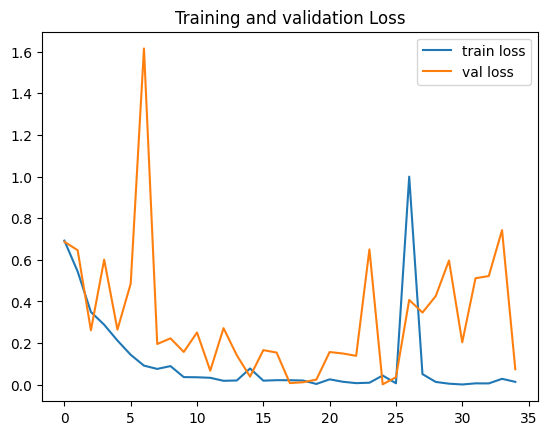

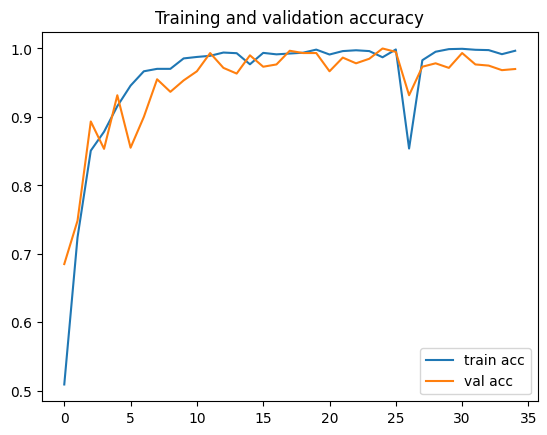

<Figure size 640x480 with 0 Axes>

In [7]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.title('Training and validation Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [8]:
model.load_weights(filepath)
Adam = tf.keras.optimizers.Adam(lr=0.001)


preds = model.evaluate_generator(test_set)
print ("Loss = ",float(preds[0]))
print ("Test Accuracy = ",float(preds[1])*100)

C:\Users\User\miniconda3\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_6028\3937893717.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  preds = model.evaluate_generator(test_set)


Loss =  0.013464261777698994
Test Accuracy =  99.58333373069763


In [10]:
probaa=[]

model.load_weights(filepath)


dir_path1=r'D:\Research\thesis\augmented\test\0'
dir_path2=r'D:\Research\thesis\augmented\test\1'

for filename in os.listdir(dir_path1):
    img=image.load_img(dir_path1+'//'+filename, target_size=(224,224,3))
    im = []
    img = image.img_to_array(img)
    img = img/255
    im.append(img)
    X= np.array(im)
    result=model.predict(X,verbose=0)
    #training_set.class_indices
    res=np.argmax(result)
    probaa.append(res)

for filename in os.listdir(dir_path2):
    img=image.load_img(dir_path2+'//'+filename, target_size=(224,224,3))
    im = []
    img = image.img_to_array(img)
    img = img/255
    im.append(img)
    X= np.array(im)
    result=model.predict(X,verbose=0)
    #training_set.class_indices
    res=np.argmax(result)
    probaa.append(res)

In [11]:
y_val=[]
for x in range (600):
  y_val.append(0)
for x in range (600):
  y_val.append(1)

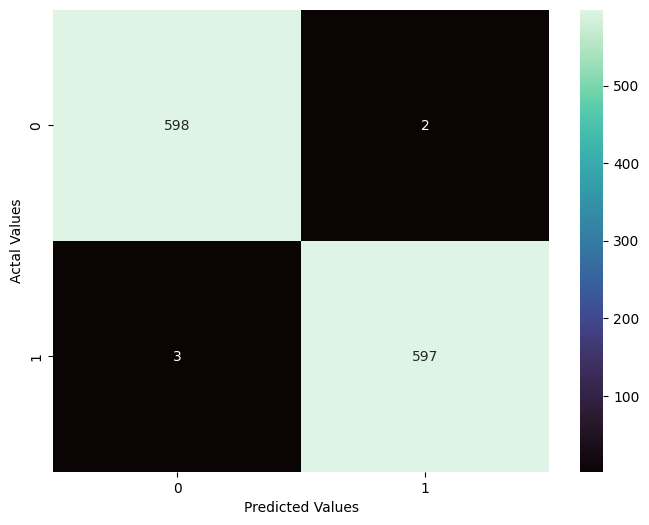

In [12]:
y_preD=probaa

cm = confusion_matrix(y_val, y_preD)
cm_df = pd.DataFrame(cm,
                     index = ['0','1'],
                     columns = ['0','1'])


plt.figure(figsize=(8,6))
sns.heatmap(cm_df,cmap='mako', annot=True, fmt='d')
#plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig(r"D:\Research\thesis\augmented\cm_new", dpi = 500)
plt.show()

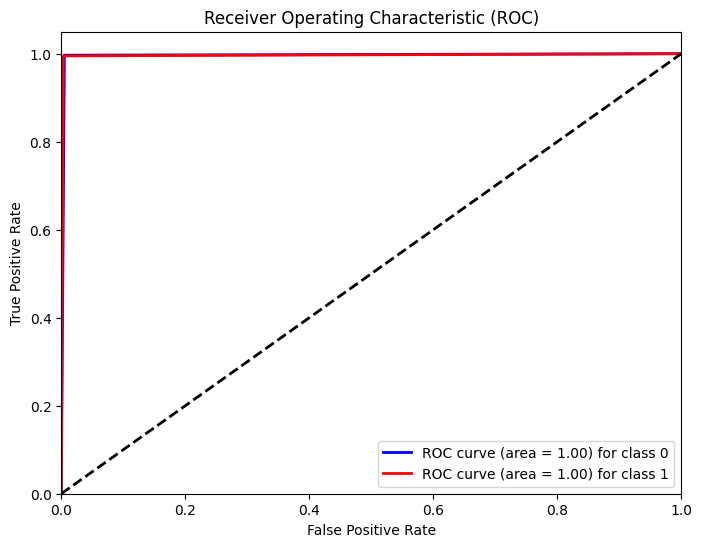

In [13]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(class_num):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_val) == i, np.array(y_preD) == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['b', 'r']
for i, color in zip(range(class_num), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig(r"D:\Research\thesis\augmented\ROC_curve.png", dpi=500)
plt.show()

In [14]:
from sklearn.metrics import roc_auc_score

# Calculate AUC for each class and print the values
for i in range(class_num):
    auc_score = roc_auc_score(np.array(y_val) == i, np.array(y_preD) == i)
    print('AUC for class {}: {:.2f}'.format(i, auc_score))

# Plot ROC curve (same code as before)

AUC for class 0: 1.00
AUC for class 1: 1.00
